# Inspect COMPAS output

* Plot the mass distribution of NSNS
* Animate it over redshift
* Extract essential information to reduce datafile

In [1]:
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import matplotlib.animation as animation
from scipy import stats
from progressbar import ProgressBar

######################################
## PLOT setttings
plt.rc('font', family='serif')
from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
rc('text', usetex=False)
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,25,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize




### Some Util functions

In [2]:
#########################################
# Mchirp
#########################################
def Mchirp(m1, m2):
    chirp_mass = np.divide(np.power(np.multiply(m1, m2), 3./5.), np.power(np.add(m1, m2), 1./5.))
    return chirp_mass   

# The NSNS mass distribution at a specific redshift

<KeysViewHDF5 ['DCOmask', 'SEED', 'merger_rate', 'redshifts']>
(2394444,)
(1757148,)
(1757148, 800)
(800,)
You might not have always calculated all rates! sum NSNS_bool = 21595, sum BHNS_bool = 175934, sum BBH_bool = 1559619
doing NSNS mergers
NSNS bool is done
extract redshift
done with read_DCO
NSNS bool is done
calculate the hist
<KeysViewHDF5 ['DCOmask', 'SEED', 'merger_rate', 'redshifts']>
(2394444,)
(1757148,)
(1757148, 100)
(100,)
You might not have always calculated all rates! sum NSNS_bool = 21595, sum BHNS_bool = 175934, sum BBH_bool = 1559619
doing NSNS mergers
NSNS bool is done
extract redshift
done with read_DCO
NSNS bool is done
calculate the hist


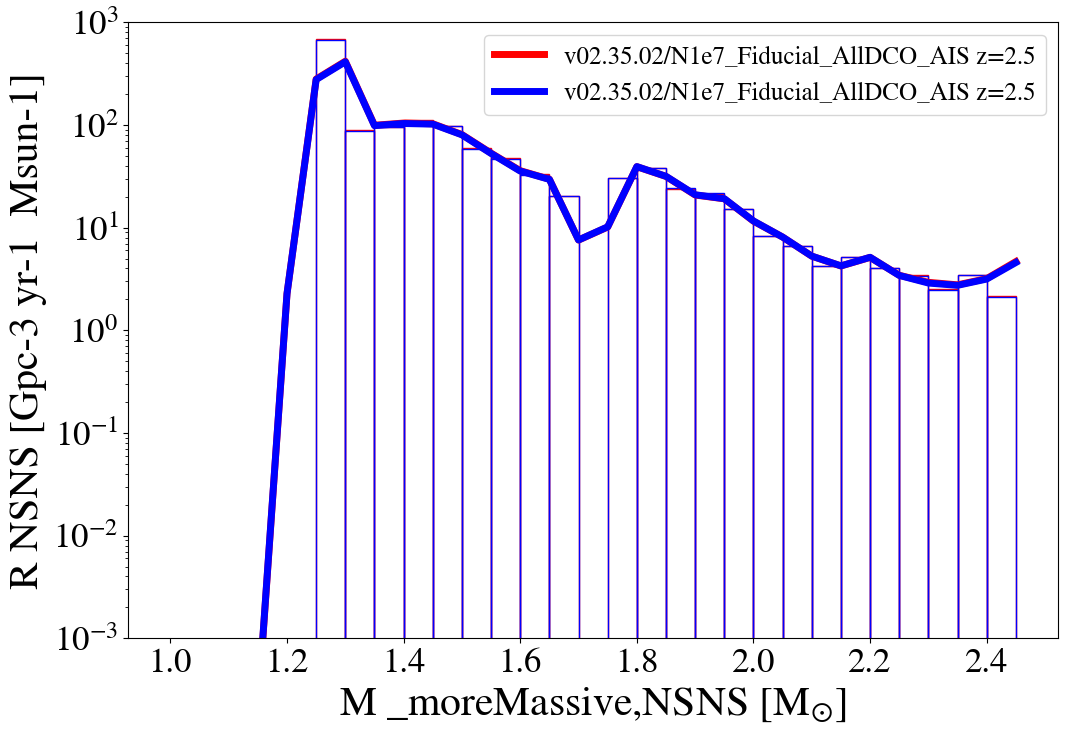

In [6]:

####################################
######   Parameters to set    ######
normalize_by_peak = False # normalize the histogram?
bootstrap         = False # bootstrap the histogram to get sampling noise?
bootstraps        = 10   # number of bootstraps to do
logx              = False # plot the log of the x-axis?
redshift_interest = 2.5
####################################


def read_DCO(var = 'v02.35.02/N1e7_Fiducial_AllDCO_AIS/', rate_filename = 'Rate_info.h5', DCO_flavour = 'NSNS',
             rate_key = 'Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048_a0.017_b1.487_c4.442_d5.886_zBinned', 
             redshift_interest  = 0.2):
    ####################################
    data_dir = '/mnt/ceph/users/lvanson/CompasOutput/' + var

    # Read the rates data
    RateFile = h5.File(f'{data_dir}/CosmicIntegration/{rate_filename}', 'r')    

    # Print the keys in the simulation data
    print(RateFile[rate_key].keys())

    # Print the shape of each dataset in the simulation data
    for key in RateFile[rate_key].keys():
        print(np.shape(RateFile[rate_key][key][()]))

    ####################################
    # Read COMPAS simulation data
    dataFile = h5.File(data_dir+'/MainRun/COMPAS_Output_wWeights.h5', 'r')

    # Set the key for the double compact object (DCO) data
    DCO_key = 'BSE_Double_Compact_Objects'
    # Set the list of keys to extract from the DCO data
    key_list = ['SEED', 'Mass(1)','Mass(2)','mixture_weight', 'Stellar_Type(1)', 'Stellar_Type(2)', 'Merges_Hubble_Time'] #'Metallicity@ZAMS(1)', 'Immediate_RLOF>CE', 'Optimistic_CE',

    # Extract DCO data to astropy table
    DCO = Table()
    for key in key_list:
        DCO[key] = dataFile[DCO_key][key][()]
    # Calculate the more massive and less massive component masses and chirp mass
    DCO['M_moreMassive'] = np.maximum(dataFile[DCO_key]['Mass(1)'][()], dataFile[DCO_key]['Mass(2)'][()])
    DCO['M_lessMassive'] = np.minimum(dataFile[DCO_key]['Mass(1)'][()], dataFile[DCO_key]['Mass(2)'][()])
    DCO['Mchirp'] = Mchirp(DCO['M_moreMassive'], DCO['M_lessMassive'])

    # Reduce the DCO table to only NSNS that merge in a Hubble time
    DCO_merger_calculated = DCO[RateFile[rate_key]['DCOmask'][()]] #RateFile[rate_key]['DCOmask'][()] reduces BSE_Double_Compact_Objects to the same shape as RateFile

    NSNS_bool = np.logical_and(DCO_merger_calculated['Stellar_Type(1)'] == 13, DCO_merger_calculated['Stellar_Type(2)'] == 13)
    BHNS_bool = np.logical_or(np.logical_and(DCO_merger_calculated['Stellar_Type(1)'] == 13, DCO_merger_calculated['Stellar_Type(2)'] == 14),
                              np.logical_and(DCO_merger_calculated['Stellar_Type(1)'] == 14, DCO_merger_calculated['Stellar_Type(2)'] == 13))
    BBH_bool  = np.logical_and(DCO_merger_calculated['Stellar_Type(1)'] == 14, DCO_merger_calculated['Stellar_Type(2)'] == 14)
    print(f'You might not have always calculated all rates! sum NSNS_bool = {sum(NSNS_bool)}, sum BHNS_bool = {sum(BHNS_bool)}, sum BBH_bool = {sum(BBH_bool)}')

    merger_bool = DCO_merger_calculated['Merges_Hubble_Time'] == True

    NSNStable, rates_NSNS, BHNStable, rates_BHNS, BBHtable, rates_BBH = [],[],[],[],[],[]
    if DCO_flavour == 'NSNS':
        print('doing NSNS mergers')
        NSNS_merger_bool = NSNS_bool * merger_bool
        NSNStable  = DCO_merger_calculated[NSNS_merger_bool]
        rates_NSNS = RateFile[rate_key]['merger_rate'][NSNS_merger_bool]
        print('NSNS bool is done')

    elif DCO_flavour == 'BHNS':
        print('doing BHNS mergers')
        BHNS_merger_bool = BHNS_bool * merger_bool
        BHNStable  = DCO_merger_calculated[BHNS_merger_bool]
        rates_BHNS = RateFile[rate_key]['merger_rate'][BHNS_merger_bool]
        print('BHNS bool is done')

    elif DCO_flavour == 'BBH':  
        print('doing BBH mergers')
        BBH_merger_bool = BBH_bool * merger_bool
        BBHtable   = DCO_merger_calculated[BBH_merger_bool]
        rates_BBH  = RateFile[rate_key]['merger_rate'][BBH_merger_bool]
        print('bbh bool is done')

    print('extract redshift')
    # Extract redshift for the current frame
    redshifts = RateFile[rate_key]['redshifts'][()]
    # Get the redshift index closest to the redshift of interest
    redshift_i = np.argmin(np.abs(redshifts - redshift_interest))

    return NSNStable, rates_NSNS, BHNStable, rates_BHNS, BBHtable, rates_BBH, redshifts, redshift_i



####################################
# Create a figure and axis for the animation
fig, ax = plt.subplots(figsize=(12, 8))

# Define the bins and x values for the KDE
Mbinwidth = 0.05
mass_key = '_moreMassive' #  'chirp'#'_lessMassive' # 
flavour = 'NSNS' #'BHNS'#
bins = np.arange(1, 2.5, Mbinwidth)
x_KDE = np.arange(1, 2.5, Mbinwidth)

rate_filenames  = ['Rate_info.h5','Rate_info_append.h5',]
rate_key        = 'Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048_a0.017_b1.487_c4.442_d5.886'
rate_keys       = [rate_key, rate_key + '_zBinned']

hist_colors = ['red', 'blue', 'green']
for v_i, variation in enumerate(['v02.35.02/N1e7_Fiducial_AllDCO_AIS','v02.35.02/N1e7_Fiducial_AllDCO_AIS']):# 'v02.35.02/N1e6_Fiducial_AllDCO_AIS/', 'v02.35.02/N1e5_Fiducial_AllDCO_AIS/']): #

    NSNStable, rates_NSNS, BHNStable, rates_BHNS, BBHtable, rates_BBH, redshifts, redshift_i = read_DCO(var = variation, rate_filename=rate_filenames[v_i], DCO_flavour = flavour,
                                                                                                        rate_key=rate_keys[v_i],redshift_interest = redshift_interest)
    print('done with read_DCO')

    if flavour == 'NSNS':
        DCO_table = NSNStable
        rates     = rates_NSNS
        print('NSNS bool is done')
    elif flavour == 'BHNS':
        DCO_table = BHNStable
        rates     = rates_BHNS  
    elif flavour == 'BBH':  
        DCO_table = BBHtable
        rates     = rates_BBH
    
    # Calculate the histogram
    print('calculate the hist')
    hist, bin_edge = np.histogram(DCO_table[f'M{mass_key}'], weights=rates[:, redshift_i], bins=bins)
    center_bins = (bin_edge[:-1] + bin_edge[1:]) / 2.

    norm = 1.
    if normalize_by_peak:
        norm = max(hist / Mbinwidth)

    # Plot the histogram
    y_vals = hist / Mbinwidth / norm
    ax.bar(center_bins, y_vals, width=np.diff(bins),
        alpha=1.0, fill=False, edgecolor= hist_colors[v_i], lw=1.)

    ########################
    # Bootstrap the histogram to get sampling noise
    if bootstrap:
        indices = np.arange(len(DCO_table[f'M{mass_key}']))
        hist_vals = np.zeros((bootstraps, len(center_bins))) 

        # Add pbar = ProgressBar() and for b in pbar(range( if you want a progress bar
        for b in range(len(hist_vals)): 
            boot_index      = np.random.choice(indices, size=len(indices), replace=True)
            hist_vals[b], _ = np.histogram(DCO_table[f'M{mass_key}'][boot_index], bins=bins, weights=rates[:, redshift_i],density=False)

        if normalize_by_peak:
            norm = max(hist / Mbinwidth)

        # calculate 90% tile
        y_vals = hist_vals / Mbinwidth / norm
        if logx:
            y_vals = y_vals*center_bins
        percentiles = np.percentile(y_vals, [10., 90.], axis=0)

        # Plot the 90% tile
        ax.fill_between(center_bins, percentiles[0],percentiles[1], alpha=0.4, color=hist_colors[v_i], zorder = 0)


    # Plot the KDE
    kernel = stats.gaussian_kde(DCO_table[f'M{mass_key}'], weights=rates[:, redshift_i],  bw_method=0.1)# bw_method='silverman' 'scott')
    KDEy_vals = kernel(x_KDE) * sum(hist) / norm  # re-normalize the KDE
    ax.plot(x_KDE, KDEy_vals, label=f'{variation} z={np.round(redshifts[redshift_i],2)}' , color=hist_colors[v_i], lw=5)

# Set the axis labels and limits
ax.set_xlabel(f'M {mass_key},{flavour} '+ '$[\mathrm{M_{\odot}} ]$', fontsize=30)
ax.set_ylabel(f'R {flavour} [Gpc-3 yr-1  Msun-1]', fontsize=30)
ax.set_yscale('log')
ax.set_ylim(1e-3, 1e3)
ax.legend(fontsize = 18)

plt.savefig(f'../ResolutionTest_{flavour}_mass_dist_z_{redshift_interest}.png')
# Show the plot
plt.show()




# Make animations of the NSNS mass distribution as a funciton of redshift

<KeysViewHDF5 ['DCOmask', 'SEED', 'merger_rate', 'redshifts']>
(523098,)
(114808,)
(114808, 100)
(100,)


MovieWriter ffmpeg unavailable; using Pillow instead.


KeyboardInterrupt: 

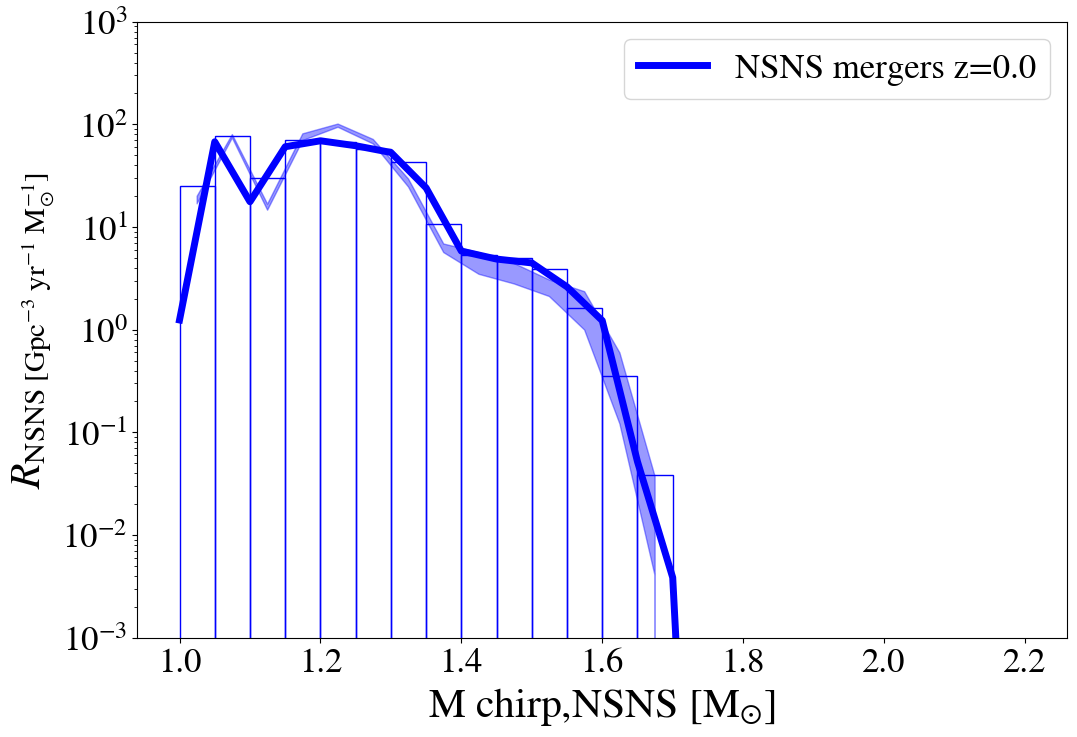

In [29]:

####################################
######   Parameters to set    ######
normalize_by_peak = False # normalize the histogram?
bootstrap         = True # bootstrap the histogram to get sampling noise?
bootstraps        = 10   # number of bootstraps to do
logx              = False # plot the log of the x-axis?
hist_col          = 'blue'
####################################


####################################
# Read the rates data
data_dir = '/mnt/ceph/users/lvanson/CompasOutput/v02.41.06/N1e7_Fiducial_NSNS/'

File = h5.File(data_dir+'/CosmicIntegration/Rate_info.h5', 'r')

# Set the key for the simulation data to analyze
sim_key = 'Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048_a0.017_b1.487_c4.442_d5.886_zBinned'

# Print the keys in the simulation data
print(File[sim_key].keys())

# Print the shape of each dataset in the simulation data
for key in File[sim_key].keys():
    print(np.shape(File[sim_key][key][()]))

####################################
# Read COMPAS simulation data
dataFile = h5.File(data_dir+'/MainRun/COMPAS_Output_wWeights.h5', 'r')

# Set the key for the double compact object (DCO) data
DCO_key = 'BSE_Double_Compact_Objects'
# Set the list of keys to extract from the DCO data
key_list = ['SEED', 'Mass(1)','Mass(2)','mixture_weight', 'Stellar_Type(1)', 'Stellar_Type(2)', 'Merges_Hubble_Time'] #'Metallicity@ZAMS(1)', 'Immediate_RLOF>CE', 'Optimistic_CE',

# Extract DCO data to astropy table
DCO = Table()
for key in key_list:
    DCO[key] = dataFile[DCO_key][key][()]
# Calculate the more massive and less massive component masses and chirp mass
DCO['M_moreMassive'] = np.maximum(dataFile[DCO_key]['Mass(1)'][()], dataFile[DCO_key]['Mass(2)'][()])
DCO['M_lessMassive'] = np.minimum(dataFile[DCO_key]['Mass(1)'][()], dataFile[DCO_key]['Mass(2)'][()])
DCO['Mchirp'] = Mchirp(DCO['M_moreMassive'], DCO['M_lessMassive'])

# Reduce the DCO table to only NSNS that merge in a Hubble time
NSNStable = DCO[File[sim_key]['DCOmask'][()]]

####################################
# Create a figure and axis for the animation
fig, ax = plt.subplots(figsize=(12, 8))

# Define the bins and x values for the KDE
Mbinwidth = 0.05
mass_key = 'chirp' #  'chirp'#'_lessMassive' # 
bins = np.arange(1, 2.2, Mbinwidth)
x_KDE = np.arange(1, 2.2, 0.05)


####################################
# Create the animation function
def animate(i):
    # Clear the axis
    ax.clear()

    # Extract the rates and redshift for the current frame
    rates = File[sim_key]['merger_rate'][()]
    redshifts = File[sim_key]['redshifts'][()]
    redshift_i = i % len(redshifts)

    # Calculate the histogram
    hist, bin_edge = np.histogram(NSNStable[f'M{mass_key}'], weights=rates[:, redshift_i], bins=bins)
    center_bins = (bin_edge[:-1] + bin_edge[1:]) / 2.

    norm = 1.
    if normalize_by_peak:
        norm = max(hist / Mbinwidth)

    # Plot the histogram
    y_vals = hist / Mbinwidth / norm
    ax.bar(center_bins, y_vals, width=np.diff(bins),
        alpha=1.0, fill=False, edgecolor= hist_col, lw=1.)

    ########################
    # Bootstrap the histogram to get sampling noise
    if bootstrap:
        indices = np.arange(len(NSNStable[f'M{mass_key}']))
        hist_vals = np.zeros((bootstraps, len(center_bins))) 

        # Add pbar = ProgressBar() and for b in pbar(range( if you want a progress bar
        for b in range(len(hist_vals)): 
            boot_index      = np.random.choice(indices, size=len(indices), replace=True)
            hist_vals[b], _ = np.histogram(NSNStable[f'M{mass_key}'][boot_index], bins=bins, weights=rates[:, redshift_i],density=False)

        if normalize_by_peak:
            norm = max(hist / Mbinwidth)

        # calculate 90% tile
        y_vals = hist_vals / Mbinwidth / norm
        if logx:
            y_vals = y_vals*center_bins
        percentiles = np.percentile(y_vals, [10., 90.], axis=0)

        # Plot the 90% tile
        ax.fill_between(center_bins, percentiles[0],percentiles[1], alpha=0.4, color=hist_col, zorder = 0)


    # Plot the KDE
    kernel = stats.gaussian_kde(NSNStable[f'M{mass_key}'], weights=rates[:, redshift_i],  bw_method=0.1)# bw_method='silverman' 'scott')
    KDEy_vals = kernel(x_KDE) * sum(hist) / norm  # re-normalize the KDE
    ax.plot(x_KDE, KDEy_vals, label=f'NSNS mergers z={np.round(redshifts[redshift_i],2)}' , color=hist_col, lw=5)

    # Set the axis labels and limits
    ax.set_xlabel(f'M {mass_key},NSNS '+ '$[\mathrm{M_{\odot}} ]$', fontsize=30)
    ax.set_ylabel('$R_{\mathrm{NSNS} \ \mathrm{[Gpc^{-3} \ yr^{-1} \ M_{\odot}^{-1}}]}$', fontsize=30)
    ax.set_yscale('log')
    ax.set_ylim(1e-3, 1e3)
    ax.legend()

# Create the animation object
ani = animation.FuncAnimation(fig, animate, frames=len(File[sim_key]['redshifts']), interval=500) 

# Save the animation as a GIF file
# ani.save(data_dir+sim+'/output/Rates/NSNS_merger_rates.gif')
# ani.save(f'../plots/N1e7_NSNS_merger_rates_M{mass_key}.gif')

# Show the animation
plt.show()




# Read and extract essential data to one hdf5 file

In [ ]:

# Define the list of simulations to analyze
# simulations = os.listdir(data_dir)
# sim_list = [sim for sim in simulations if sim not in ['EssentialData', 'Grid_Call_Stroopwafel.py']]

data_dir = '/mnt/ceph/users/lvanson/CompasOutput/v02.41.06/'
sim_list = ['N1e6_Fiducial_NSNS', 'N1e7_Fiducial_NSNS']

# Define the list of keys to extract from the DCO data
key_list = ['SEED', 'Mass(1)', 'Mass(2)', 'mixture_weight',
            'Stellar_Type(1)', 'Stellar_Type(2)', 'Merges_Hubble_Time'] #'Metallicity@ZAMS(1)', 'Immediate_RLOF>CE', 'Optimistic_CE',

# Define the name of the output HDF5 file
output_file = 'ReducedCOMPASData.h5'

# Loop over all simulations
with h5.File(data_dir+'/'+output_file, 'w') as f:
    for sim in sim_list:
        # try:
        print('Creating group for simulation:', sim)
        # Create a group for the current simulation
        sim_group = f.create_group(sim)

        # Open the HDF5 file containing the rates data
        File = h5.File(data_dir+sim+'/CosmicIntegration/Rate_info.h5', 'r')

        # Set the key for the simulation data to analyze
        SFRD_key = 'Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048_a0.017_b1.487_c4.442_d5.886_zBinned'

        # Open the HDF5 file containing the COMPAS simulation data
        dataFile = h5.File(data_dir+sim+'/MainRun/COMPAS_Output_wWeights.h5', 'r')

        # Extract the DCO data for each key in the list
        DCO = Table()
        for key in key_list:
            DCO[key] = dataFile['BSE_Double_Compact_Objects'][key][()]

        # Calculate the more massive and less massive component masses and chirp mass
        DCO['M_moreMassive'] = np.maximum(dataFile['BSE_Double_Compact_Objects']['Mass(1)'][()], dataFile['BSE_Double_Compact_Objects']['Mass(2)'][()])
        DCO['M_lessMassive'] = np.minimum(dataFile['BSE_Double_Compact_Objects']['Mass(1)'][()], dataFile['BSE_Double_Compact_Objects']['Mass(2)'][()])
        DCO['Mchirp'] = Mchirp(DCO['M_moreMassive'], DCO['M_lessMassive'])

        # Reduce the DCO table to only NSNS that merge in a Hubble time
        NSNStable = DCO[File[SFRD_key]['DCOmask'][()]]

        # Save the NSNS table to the HDF5 file
        dco_group = sim_group.create_group('NSNS')
        for dco_key in NSNStable.keys():
            dco_group.create_dataset(dco_key, data=NSNStable[dco_key][()])

        # Save the Rate info to the HDF5 file
        rate_group = sim_group.create_group('Rate_info')
        for key in File[SFRD_key].keys():
            rate_group.create_dataset(key, data=File[SFRD_key][key][()])
        # except:
        #     print('error for ', sim)
        #     continue

In [ ]:
data =  h5.File(data_dir+'ReducedCOMPASData.h5', 'r')
print(data['N1e6_Fiducial_NSNS'].keys() )

print(data['N1e6_Fiducial_NSNS']['Rate_info'].keys() )


print(data['N1e6_Fiducial_NSNS']['NSNS'].keys() )
